# Using the Virtual AWG

The virtual AWG is an abstraction layer, which lets you define waveform sequences. The sequences can be upload to gates and played. The virtual AWG takes care of gates to AWG channel relation and creates the markers for the digitizer and interconnecting AWG's.

In this example we will discuss the use of the virtual AWG in combination with a digitizer. We used the V1 setup with one Tektronix 5014 AWG's and one Spectrum M4i digitizer card as hardware.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from qupulse.pulses import FunctionPT
from qupulse.pulses import SequencePT

from qcodes.utils.validators import Numbers
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import ManualParameter
from qcodes_contrib_drivers.drivers.Spectrum.M4i import M4i
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014

from qtt.instrument_drivers.virtualAwg.sequencer import DataTypes
from qtt.instrument_drivers.virtualAwg.virtual_awg import VirtualAwg
from qtt.measurements.scans import measuresegment as measure_segment

First we need to create a HardwareSettings class that contains the awg map and the awg to gates. The awg map contains the relation between the AWG channels, markers and gates. The awg to gate defines the voltage loss caused by attenuation, filtering, etc. of the AWG channels. This is, the ratio between AWG channel output value and the voltage on the gate. In the past the class HardwareSettings was called hardware.

In [4]:
class HardwareSettings(Instrument):

    def __init__(self, name='settings'):
        """ Contains the quantum chip settings:
                awg_map: Relation between gate name and AWG number and AWG channel.
                awg_to_gate: Scaling ratio between AWG output value and the voltoge on the gate.
        """
        super().__init__(name)
        awg_gates = {'X2': (0, 1), 'P7': (0, 2), 'P6': (0, 3), 'P5': (0, 4),
                     'P2': (1, 1), 'X1': (1, 2), 'P3': (1, 3), 'P4': (1, 4)}
        awg_markers = {'m4i_mk': (0, 4, 1)}
        self.awg_map = {**awg_gates, **awg_markers}

        for awg_gate in awg_gates:
            parameter_name = 'awg_to_{}'.format(awg_gate)
            parameter_label = '{} (factor)'.format(parameter_name)
            self.add_parameter(parameter_name, parameter_class=ManualParameter,
                               initial_value=1000.0, label=parameter_label, vals=Numbers(1, 1000))

Last we define some functions to quickly plot the digitizer output data.

In [6]:
def update_awg_settings(virtual_awg, sampling_rate, amplitude, marker_low, marker_high):
    for awg_number in range(len(virtual_awg.awgs)):
        virtual_awg.update_setting(awg_number, 'sampling_rate', sampling_rate)
        virtual_awg.update_setting(awg_number, 'amplitudes', amplitude)
        virtual_awg.update_setting(awg_number, 'marker_low', marker_low)
        virtual_awg.update_setting(awg_number, 'marker_high', marker_high)

def plot_data_1d(digitizer_data, label_x_axis='', label_y_axis=''):
    plt.figure(); 
    plt.clf(); 
    plt.xlabel(label_x_axis)
    plt.ylabel(label_y_axis)
    plt.plot(digitizer_data.flatten(),'.b')
    plt.show()

def plot_data_2d(digitizer_data, label_x_axis='', label_y_axis='', label_colorbar=''):
    plt.figure(); 
    plt.clf(); 
    im = plt.imshow(digitizer_data[0])
    cbar = plt.colorbar(im)
    plt.xlabel(label_x_axis)
    plt.ylabel(label_y_axis)
    cbar.ax.set_ylabel(label_colorbar)
    plt.show()


## Initializing the virtual AWG and digitizer

Before we can start using the virtual AWG, an AWG output channel should be directly connected to the digitizer channel. The virtual AWG can be tested using this connection. We connected gate 'X2' to digitizer channel 0 for the XLD setup.

After the hardware change the connection to the AWG's and digitizer. The hardware needs specific settings in order to work properly.

In [7]:
digitizer = M4i(name='digitizer')

sample_rate_in_Hz = 2e6
digitizer.sample_rate(sample_rate_in_Hz)

timeout_in_ms = 10 * 1000
digitizer.timeout(timeout_in_ms)

millivolt_range = 2000
digitizer.initialize_channels(mV_range=millivolt_range)

import pyspcm
external_clock_mode = pyspcm.SPC_CM_EXTREFCLOCK
digitizer.clock_mode(external_clock_mode)

reference_clock_10mHz = int(1e7)
digitizer.reference_clock(reference_clock_10mHz)

# Initialize Tektronix AWG's
trigger_level_in_Volt = 0.5
clock_frequency_in_Hz = 1.0e7

address_awg1 = 'GPIB1::5::INSTR'
awg1 = Tektronix_AWG5014(name='awg1', address=address_awg1)
awg1.clock_freq(clock_frequency_in_Hz)
awg1.trigger_level(trigger_level_in_Volt)

Connected to: TEKTRONIX AWG5014 (serial:B010106, firmware:SCPI:99.0 FW:3.1.141.647) in 0.48s


The virtual AWG and the settings object can be created once the hardware is connected.

In [8]:
settings = HardwareSettings()
virtual_awg = VirtualAwg([awg1], settings)

uptime_in_seconds = 1.0e-5
marker_delay_in_sec = 3.5e-5

virtual_awg.update_digitizer_marker_settings(uptime_in_seconds, marker_delay_in_sec)

output_amplitude = 0.5
marker_low_level = 0.0
marker_high_level = 2.6

update_awg_settings(virtual_awg, clock_frequency_in_Hz, output_amplitude, marker_low_level, marker_high_level)

## Sawtooth Sequence

The most simple sequence to create is a sawtooth with a certain width. First upload the sawtooth to the AWG using the sweep_gates function on gate X2.

In [9]:
output_gate = 'X2'
mV_sweep_range = 50
sec_period = 1.0e-3
sweep_data = virtual_awg.sweep_gates({output_gate: 1}, mV_sweep_range, sec_period)

Then enable the AWG channel and run the sequence. Start the recording of the digitizer with averaging a 100 times. Afterwards the AWG is stopped and the channel disabled. 

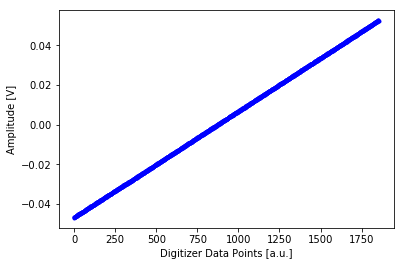

In [10]:
virtual_awg.enable_outputs([output_gate])
virtual_awg.run()

readout_channels = [2]
number_of_averages = 100
data = measure_segment(sweep_data, number_of_averages, digitizer, readout_channels)

virtual_awg.stop()
virtual_awg.disable_outputs([output_gate])

plot_data_1d(data, 'Digitizer Data Points [a.u.]', 'Amplitude [V]')

## Pulse Sequence

Run a square wave on gate X2. Collect the data using a digitizer with 100 times averaging.

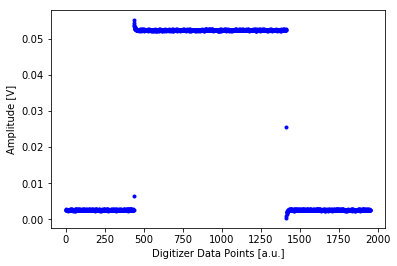

In [11]:
output_gate = 'X2'
mV_sweep_range = 50
sec_period = 1.0e-3
sweep_data = virtual_awg.pulse_gates({output_gate: 1}, mV_sweep_range, sec_period)

virtual_awg.enable_outputs([output_gate])
virtual_awg.run()

readout_channels = [2]
number_of_averages = 100
data = measure_segment(sweep_data, number_of_averages, digitizer, readout_channels, process=False)

virtual_awg.stop()
virtual_awg.disable_outputs([output_gate])

plot_data_1d(data, 'Digitizer Data Points [a.u.]', 'Amplitude [V]')

## Pulse combination on Two Gates

Supplies sawtooth signals to a linear combination of gates, which effectively does a 2D scan. Collect the data of one axes using the digitizer with 100 times averaging.

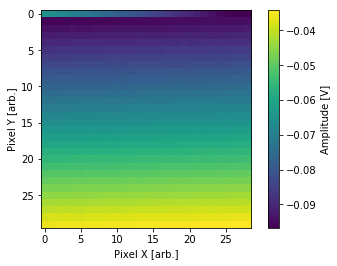

In [12]:
sec_period = 5.0e-5
resolution = [32, 32]
mV_sweep_ranges = [100, 100]
output_gates = [{'X2': 1}, {'P7': 1}]
sweep_data = virtual_awg.sweep_gates_2d(output_gates, mV_sweep_ranges, sec_period, resolution)

virtual_awg.enable_outputs(['X2', 'P7'])
virtual_awg.run()

number_of_averages = 100
readout_channels = [2]
data = measure_segment(sweep_data, number_of_averages, digitizer, readout_channels)

virtual_awg.disable_outputs(['X2', 'P7'])
virtual_awg.stop()

plot_data_2d(data, 'Pixel X [a.u.]', 'Pixel Y [a.u.]', 'Amplitude [V]')

## Apply custom Sequence on Gate

Create a decaying sine-wave sequence using QuPulse

In [13]:
sec_to_ns = 1.0e9

mV_amplitude = 25
sec_period = 1.0e-3
sine_decay = 5e5
sine_period = 2 * np.pi * 1e-2 * sec_period

pulse_function = FunctionPT('alpha*exp(-t/tau)*sin(phi*t)', 'duration')
input_variables = {'alpha': mV_amplitude, 'tau': sine_decay, 'phi': sine_period, 'duration': sec_period * sec_to_ns}

other = (pulse_function, input_variables)
sequence_data = {'name': 'test', 'wave': SequencePT(*(other,)), 'type': DataTypes.QU_PULSE}
sequence = {'X2': sequence_data}

sequence.update(virtual_awg._VirtualAwg__make_markers(sec_period))

Upload the QuPulse sequence onto the AWG. Play the sequence and collect the data using the digitizer with 100 averaging.

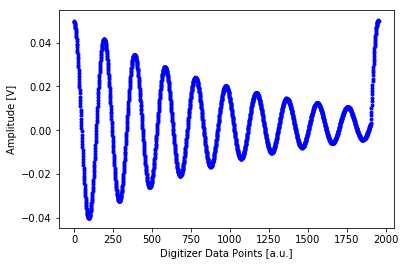

In [15]:
sweep_data = virtual_awg.sequence_gates(sequence)
sweep_data.update({
    'period': sec_period,
    'samplerate': virtual_awg.awgs[0].retrieve_setting('sampling_rate'),
    'markerdelay': virtual_awg.digitizer_marker_delay()
})

virtual_awg.enable_outputs(['X2'])
virtual_awg.run()

number_of_averages = 100
readout_channels = [2]
data = measure_segment(sweep_data, number_of_averages, digitizer, readout_channels, process=False)

virtual_awg.disable_outputs(['X2'])
virtual_awg.stop()

plot_data_1d(data, 'Digitizer Data Points [a.u.]', 'Amplitude [V]')